In [2]:
import dice_ml

/Users/son/anaconda3/envs/xai/lib/python3.10/site-packages/dice_ml/utils/exception.py:12: UserWarning: UserConfigValidationException will be deprecated from dice_ml.utils. Please import UserConfigValidationException from raiutils.exceptions.
  warnings.warn("UserConfigValidationException will be deprecated from dice_ml.utils. "


In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

In [163]:
def plot_data(data,labels=None):
    """
    Affiche des donnees 2D
    :param data: matrice des donnees 2d
    :param labels: vecteur des labels (discrets)
    :return:
    """
    if labels is not None:
        labels = labels.reshape(-1)
    cols,marks = ["red", "green", "blue", "orange", "black", "cyan"],[".","+","*","o","x","^"]
    if labels is None:
        plt.scatter(data[:,0],data[:,1],marker="x")
        return
    for i,l in enumerate(sorted(list(set(labels.flatten())))):
        plt.scatter(data[labels==l,0],data[labels==l,1],c=cols[i],marker=marks[i])

def plot_frontiere_torch(data,f,step=20):
    """ Trace un graphe de la frontiere de decision de f
    :param data: donnees
    :param f: fonction de decision
    :param step: pas de la grille
    :return:
    """
    grid,x,y=make_grid(data=data,step=step)
    plt.contourf(x,y,f(grid).detach().numpy().reshape(x.shape),colors=('gray','blue'),levels=[-1,0,1])

def plot_frontiere(data,f,step=20):
    """ Trace un graphe de la frontiere de decision de f
    :param data: donnees
    :param f: fonction de decision
    :param step: pas de la grille
    :return:
    """
    grid,x,y=make_grid(data=data,step=step)
    plt.contourf(x,y,f(grid).detach().numpy().reshape(x.shape),colors=('gray','blue'),levels=[-1,0,1])

def make_grid(data=None,xmin=-5,xmax=5,ymin=-5,ymax=5,step=20):
    """ Cree une grille sous forme de matrice 2d de la liste des points
    :param data: pour calcluler les bornes du graphe
    :param xmin: si pas data, alors bornes du graphe
    :param xmax:
    :param ymin:
    :param ymax:
    :param step: pas de la grille
    :return: une matrice 2d contenant les points de la grille
    """
    if data is not None:
        xmax, xmin, ymax, ymin = np.max(data[:,0]),  np.min(data[:,0]), np.max(data[:,1]), np.min(data[:,1])
    x, y =np.meshgrid(np.arange(xmin,xmax,(xmax-xmin)*1./step), np.arange(ymin,ymax,(ymax-ymin)*1./step))
    grid=np.c_[x.ravel(),y.ravel()]
    return grid, x, y

In [5]:
def halfmoon(n_samples, epsilon):
  pts = np.linspace(0,180, n_samples//2)* np.pi / 180
  haut = np.hstack((np.cos(pts).reshape((-1,1)), np.sin(pts).reshape((-1,1))))
  bas = np.hstack((1-np.cos(pts).reshape((-1,1)), 0.5-np.sin(pts).reshape((-1,1))))
  data = np.vstack((haut,bas))
  data[:,0]+=np.random.normal(0,epsilon,n_samples)
  data[:,1]+=np.random.normal(0,epsilon,n_samples)
  y = np.zeros(n_samples)
  y[n_samples//2:]=1
  return data, y

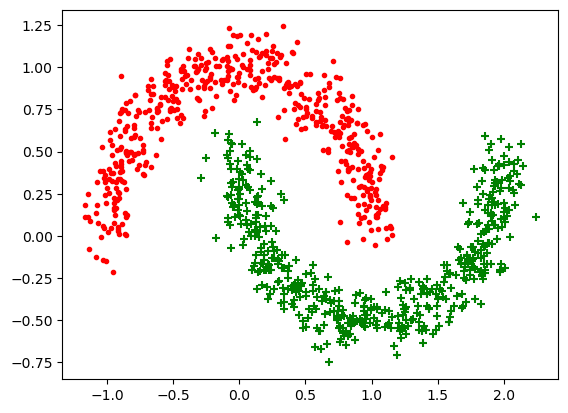

In [19]:
#Param
nbex = 1000
epsilon = 0.1

# x, y = make_moons(n_samples=nbex, noise=noise)
data, y = halfmoon(nbex, epsilon)
plot_data(data, y)

In [21]:
df_halfmoon = pd.DataFrame(data, columns=['x', 'y'])
df_halfmoon['target'] = y
df_halfmoon.head()

,x,y,target
0,0.858312,-0.027223,0.0
1,1.058080,0.087102,0.0
2,0.979543,0.025196,0.0
3,1.126570,-0.006988,0.0
4,1.145357,0.176985,0.0


In [22]:
dataDice = dice_ml.Data(dataframe = df_halfmoon, \
                        continuous_features = ['x', 'y'],\
                        outcome_name = 'target'
                        )

## Modèle

In [106]:
class RegLog(torch.nn.Module):
    def __init__(self, dim_in, dim_out, lr = 0.01):
        super().__init__()
        self.epoch = 30
        self.lr = lr
        self.linear = torch.nn.Linear(dim_in, dim_out)
        self.loss = torch.nn.BCELoss()
        self.optim = torch.optim.Adam(self.linear.parameters(), lr = self.lr)
        self.sig = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.linear(x)
        return self.sig(x)
    
    def fit(self, x, y):
        for i in range(self.epoch):
            y_pred = self.forward(x)
            loss = self.loss(y_pred, y)
            loss.backward()
            self.optim.step()
            self.optim.zero_grad()

    def predict(self, x, thresh = 0.5):
        y_pred = self.forward(x)
        y_pred[y_pred>=thresh]=1
        y_pred[y_pred<thresh]=0
        return y_pred

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [24]:
def makeData(data, y):
    idx = np.arange(len(y))
    idx_train, idx_test = train_test_split(idx, test_size=0.2, shuffle = True)

    data_train = data[idx_train]
    data_test = data[idx_test]
    y_train = y[idx_train]
    y_test = y[idx_test]

    return data_train, y_train, data_test, y_test

In [25]:
data_train, y_train, data_test, y_test = makeData(data, y)

Regression logistique

In [27]:
clf = LogisticRegression()
clf.fit(data_train, y_train)
accuracy_score(y_test, clf.predict(data_test))

0.855

In [34]:
dim_in = data_train.shape[1]
dim_out = 1

In [90]:
tensor_x_train = torch.from_numpy(data_train)
tensor_x_train = torch.tensor(tensor_x_train, dtype=torch.float32)
tensor_x_test = torch.from_numpy(data_test)
tensor_x_test = torch.tensor(tensor_x_test, dtype=torch.float32)



tensor_y_train = torch.from_numpy(y_train)
tensor_y_train = tensor_y_train.view(-1, 1)
tensor_y_train = torch.tensor(tensor_y_train, dtype=torch.float32)

tensor_y_test = torch.from_numpy(y_test)
tensor_y_test = tensor_y_test.view(-1, 1)
tensor_y_test = torch.tensor(tensor_y_test, dtype=torch.float32)

/var/folders/f6/jcgp3r696njgrljx2q71szvh0000gn/T/ipykernel_4230/2250120223.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_x_train = torch.tensor(tensor_x_train, dtype=torch.float32)
/var/folders/f6/jcgp3r696njgrljx2q71szvh0000gn/T/ipykernel_4230/2250120223.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_x_test = torch.tensor(tensor_x_test, dtype=torch.float32)
/var/folders/f6/jcgp3r696njgrljx2q71szvh0000gn/T/ipykernel_4230/2250120223.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_y_train = torch.tensor(

In [107]:
clf_torch = RegLog(dim_in=dim_in, dim_out=dim_out)
clf_torch.fit(tensor_x_train, tensor_y_train)

In [110]:
y_test_pred = clf_torch.predict(tensor_x_test)
accuracy_score(y_test, y_pred=y_test_pred.detach().numpy())

0.83

DICE

In [111]:
model = dice_ml.Model(model=clf_torch, backend="PYT")

In [113]:
explainer = dice_ml.Dice(dataDice, model)

In [137]:
counterfacuals = explainer.generate_counterfactuals(\
    df_halfmoon[700:701].drop(columns=['target']),
    total_CFs=3,\
    desired_class ="opposite",\
    proximity_weight=0.5,\
    diversity_weight=1.0,\
    features_to_vary="all",\
    permitted_range=None,\
    posthoc_sparsity_param=0.1
    )

100%|██████████| 1/1 [00:00<00:00, 23.16it/s]


In [138]:
counterfacuals.visualize_as_dataframe()

Query instance (original outcome : 1)


,x,y,target
0,0.555849,-0.495902,1



Diverse Counterfactual set (new outcome: 0.0)


,x,y,target
0,0.555849,0.198187,0
1,0.555849,0.879428,0
2,-0.435308,-0.495902,0


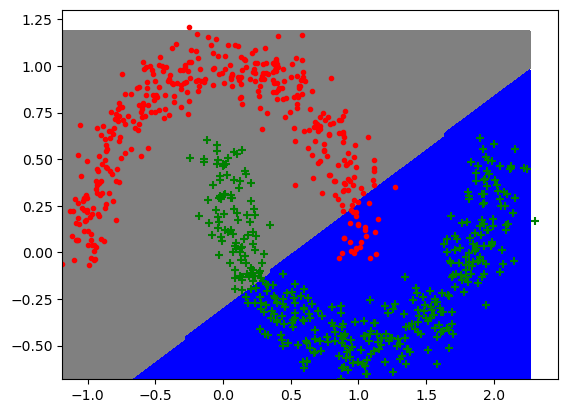

In [162]:
plot_frontiere_torch(data_train,lambda x : clf_torch.predict(torch.tensor(x, dtype=torch.float32)),step=100)
plot_data(data_train,y_train)